Libraries & Parameters

In [1]:
!pip install -q awswrangler

import awswrangler as wr
import pandas as pd

import boto3
import pytz

import numpy as np
!pip install -U -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from sagemaker import get_execution_role

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# Get Sagemaker Role
role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210503T205912 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::506926764659:role/service-role/AmazonSageMaker-ExecutionRole-20210503T205912


___
# 1.) Download Data

## S3 parameters

In [3]:
# Flight data from Sagemaker Data Wrangler
bucket = 'sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default'
filename = 'part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'
path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from entire year of 2011
# bucket = 'from-public-data/carrier-perf/transformed'
# filename = 'airOT2011all.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from 2011_01 
# bucket = 'from-public-data/carrier-perf/transformed/airOT2011'
# filename = 'airOT201101.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)


# ________________________________________________________________
# Supporting dataset useful for EDA and understanding data
#   - airport codes
#   - airline codes
bucket2 = 'from-public-data/carrier-perf/raw'
file_airport = 'airports.csv'
file_airline = 'airlines.csv'

path_to_file_airport = 's3://{}/{}'.format(bucket2, file_airport)
path_to_file_airline = 's3://{}/{}'.format(bucket2, file_airline)

=== === === === ===
## Download data from S3

### 1. Flights Performance dataset

In [4]:
df = wr.s3.read_csv([path_to_file])
# df

A whopping 7,294,649 rows (records) of JUST year 2007!  Thanks to all the Sagemaker Data Wrangler, I was able to already do some data cleaning and adjustment:
  - Create new variable `late_flight` depending on `DEP_DELAY`
  - Trim value to remove outliers for `DEP_DLAY`
  - Drop records for Cancelled flights `CANCELED` == 1 (doesn't make much sense to have flights that's irrelevant to flights delay when flight never occur)

### 2. Airports & Airlines dataset

In [5]:
df_airports = wr.s3.read_csv([path_to_file_airport])
df_airlines = wr.s3.read_csv([path_to_file_airline])
# df_airlines

=== === === === ===
## Initial Data Clean-up and Organization

In [6]:
# rename 'DAY_OF_MONTH' column to 'DAY' (in prep of transforming to datetime format)
df = df.rename(columns={'DAY_OF_MONTH': 'DAY'})
# df

### 1. Date / Time modifications

Make date and time more appropriate.  This will make it easier when making plots.

In [7]:
# Create a datetime field `DATE`
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [8]:
# Convert 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [9]:
df['DEP_TIME'] = df['DEP_TIME'].apply(format_heure)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_heure)

### 2. Organize Columns

Let's organize columns (features) to be more logical

In [10]:
variables_to_remove = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
df.drop(variables_to_remove, axis = 1, inplace = True)

df = df[[
    'DATE',
    'YEAR',
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'DEP_TIME',
    'DEP_DELAY',
    'DEP_DELAY_no_outlier',
    'ACTUAL_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'ARR_TIME',
    'ARR_DELAY',
    'CARRIER_DELAY',
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'late_flight']]

In [11]:
df_AA = df.loc[df['UNIQUE_CARRIER'] == 'AA']

# Set this in prep. for model training
df_toTrain = df_AA

distinct_airlines = df_AA.UNIQUE_CARRIER.unique()
print('New dataset has {0} records with {1} variables, containing only airlines {2}'.format(df_AA.shape[0], df_AA.shape[1], distinct_airlines))

New dataset has 615933 records with 22 variables, containing only airlines ['AA']


In [12]:
df_AA

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,AIR_TIME,DISTANCE,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight
20534,2007-01-01,2007,1,1,1,AA,JFK,LAX,08:54:00,-6.0,...,333.0,2475.0,12:30:00,20.0,0.0,0.0,20.0,0.0,0.0,late
20535,2007-01-02,2007,1,2,2,AA,JFK,LAX,08:55:00,-5.0,...,326.0,2475.0,12:35:00,25.0,0.0,0.0,25.0,0.0,0.0,late
20536,2007-01-03,2007,1,3,3,AA,JFK,LAX,08:56:00,-4.0,...,312.0,2475.0,12:13:00,3.0,NaN,NaN,NaN,NaN,NaN,late
20537,2007-01-04,2007,1,4,4,AA,JFK,LAX,09:01:00,1.0,...,352.0,2475.0,12:49:00,39.0,0.0,0.0,39.0,0.0,0.0,late
20538,2007-01-05,2007,1,5,5,AA,JFK,LAX,08:55:00,-5.0,...,360.0,2475.0,13:00:00,50.0,0.0,0.0,50.0,0.0,0.0,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6770764,2007-12-29,2007,12,29,6,AA,ORD,MCI,10:02:00,22.0,...,69.0,403.0,11:30:00,25.0,0.0,21.0,3.0,0.0,1.0,late
6770765,2007-12-30,2007,12,30,7,AA,ORD,MCI,09:33:00,-7.0,...,66.0,403.0,10:58:00,-7.0,NaN,NaN,NaN,NaN,NaN,late
6770766,2007-12-31,2007,12,31,1,AA,ORD,MCI,09:36:00,-4.0,...,79.0,403.0,11:23:00,18.0,0.0,0.0,18.0,0.0,0.0,late
6770767,2007-12-13,2007,12,13,4,AA,BOS,MIA,09:15:00,0.0,...,176.0,1258.0,12:56:00,11.0,NaN,NaN,NaN,NaN,NaN,late


___
# 2.) Explorational Data Analysis

## Distribution of Target (dependent) Variable `late_flight`

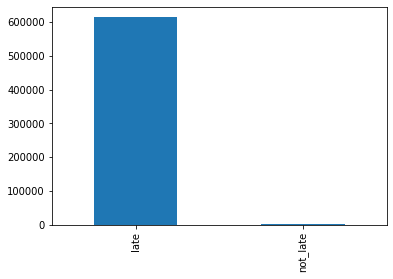

In [13]:
df_AA.late_flight.value_counts().plot(kind='bar')

In [14]:
df_AA.late_flight.value_counts()

late        614475
not_late      1458
Name: late_flight, dtype: int64

**NOTE** Looks like a pretty imbalance distribution of target variable.  Will probably need to use SMOTE and create synthetic data for the minority class.

## Corrleations

Text(0.5, 1, 'Correlation Heatmap')

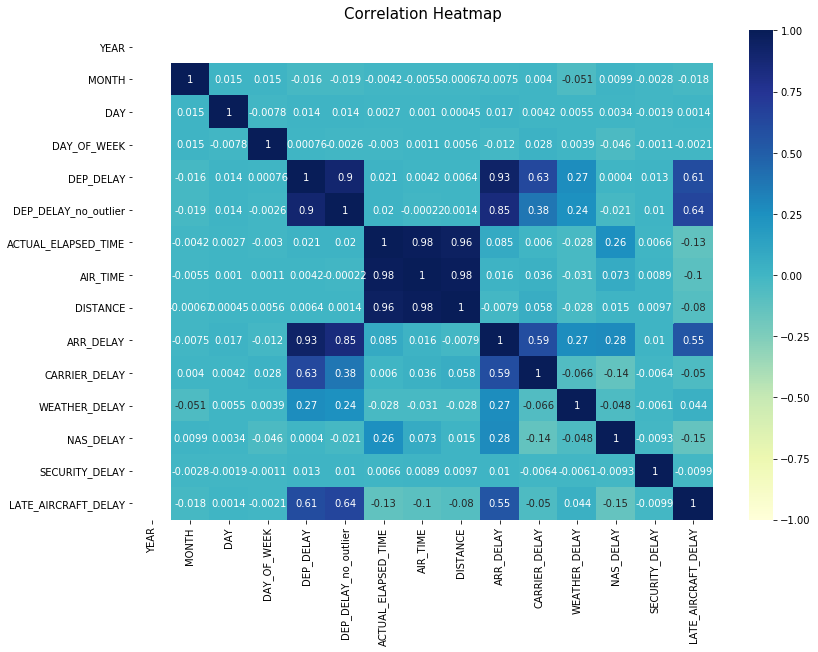

In [16]:
# increase figure size
plt.figure(figsize=(13, 9))
heatmap = sns.heatmap(df_AA.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")

# define title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12)

# ref. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

**NOTE** Looks like high correlation between:
  - `DEP_DELAY_no_outlier` :: `ARR_DELAY`, which could makes logical sense because if you are late departing, then you are likely to be late arriving
  - `ACTUAL_ELAPSED_TIME` :: `DISTANCE` :: `AIR_TIME`, which make sense as each 3-variables are referencing same part of flight

# 3.) Train Model

In [17]:
# Download PyCaret
!pip install pycaret --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## a. Get the Data

In [36]:
data = df_toTrain.sample(frac=0.10, random_state=123)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (61593, 22)
Unseen Data For Predictions: (7233056, 22)


## b. Setting Up Environment in PyCaret

In [37]:
from pycaret.classification import *
exp = setup(data = data, 
            numeric_features = ['YEAR', 'MONTH','DAY','DAY_OF_WEEK'],
            ignore_features = ['DEP_DELAY', 'ARR_DELAY', 'AIR_TIME', 'ARR_TIME'],
            target = 'late_flight',
            fix_imbalance = True,
            normalize = True,
            transformation = True,
            ignore_low_variance = True,
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.95,
            use_gpu = True,
            fold = 2
           )

,Description,Value
0,session_id,7316
1,Target,late_flight
2,Target Type,Binary
3,Label Encoded,"late: 0, not_late: 1"
4,Original Data,"(61593, 22)"
5,Missing Values,True
6,Numeric Features,12
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


## c. Comparing all models

In [38]:
# ref. 
#   -- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=compare_models#pycaret.classification.compare_models
#   -- https://machinelearningmastery.com/k-fold-cross-validation/

best_model = compare_models(cross_validation=False)
# best_model = compare_modelfold=old=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9973,0.7896,0.0000,0.0000,0.0000,-0.0002,-0.0005,8.3500
et,Extra Trees Classifier,0.9971,0.7082,0.0000,0.0000,0.0000,-0.0007,-0.0010,9.1600
lightgbm,Light Gradient Boosting Machine,0.9967,0.9718,0.0213,0.0625,0.0317,0.0305,0.0350,1.9500
qda,Quadratic Discriminant Analysis,0.9956,0.5203,0.0426,0.0526,0.0471,0.0449,0.0451,1.6900
dt,Decision Tree Classifier,0.9946,0.5092,0.0213,0.0185,0.0198,0.0171,0.0172,11.7000
knn,K Neighbors Classifier,0.9860,0.5000,0.0213,0.0047,0.0077,0.0035,0.0046,11.9300
ada,Ada Boost Classifier,0.9693,0.9738,0.5319,0.0439,0.0810,0.0767,0.1463,9.1300
nb,Naive Bayes,0.9639,0.7485,0.5319,0.0373,0.0697,0.0653,0.1339,0.4400
gbc,Gradient Boosting Classifier,0.9631,0.9728,0.7234,0.0484,0.0908,0.0864,0.1810,40.1000
lr,Logistic Regression,0.9242,0.6814,0.2128,0.0073,0.0141,0.0092,0.0267,10.4200


# 4.) Create Model(s)

## a. Random Forest Classifier

In [28]:
rf = create_model('rf')
# rf = create_model('rf', cross_validation=False)

# trained model object is stored as `rf`
# print(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
SD,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7973, verbose=0,
                       warm_start=False)


## b. Extra Trees Classifier

In [31]:
et = create_model('et')
# et = create_model('et', cross_validation=False)

# trained model object is stored as `et`
# print(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
SD,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7973, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## c. Light Gradient Boosting Machine

In [39]:
lightgbm = create_model('lightgbm')
# lightgbm = create_model('lightgbm', cross_validation=False)

# trained model object is stored as `lightgbm`
print(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9973,0.9728,0.0204,0.0833,0.0328,0.0319,0.0402
1,0.9975,0.9715,0.0204,0.1667,0.0364,0.0359,0.0576
Mean,0.9974,0.9722,0.0204,0.1250,0.0346,0.0339,0.0489
SD,0.0001,0.0007,0.0000,0.0417,0.0018,0.0020,0.0087


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7316, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


# 5.) Tune Model(s)

## a. Light Gradient Boosting Machine

In [40]:
tuned_lightgbm = tune_model(lightgbm, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_lightgbm`
print(tuned_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9976,0.9773,0.0204,0.2500,0.0377,0.0374,0.0709
1,0.9976,0.9728,0.0204,0.2000,0.0370,0.0366,0.0632
Mean,0.9976,0.9751,0.0204,0.2250,0.0374,0.0370,0.0671
SD,0.0000,0.0023,0.0000,0.0250,0.0003,0.0004,0.0038


LGBMClassifier(bagging_fraction=0.5, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=96, min_child_weight=0.001, min_split_gain=0.5,
               n_estimators=260, n_jobs=-1, num_leaves=150, objective=None,
               random_state=7316, reg_alpha=1e-06, reg_lambda=0.1, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


# 6.) Models Performance

## a. Light Gradient Boosting Machine

### i. Features Importance

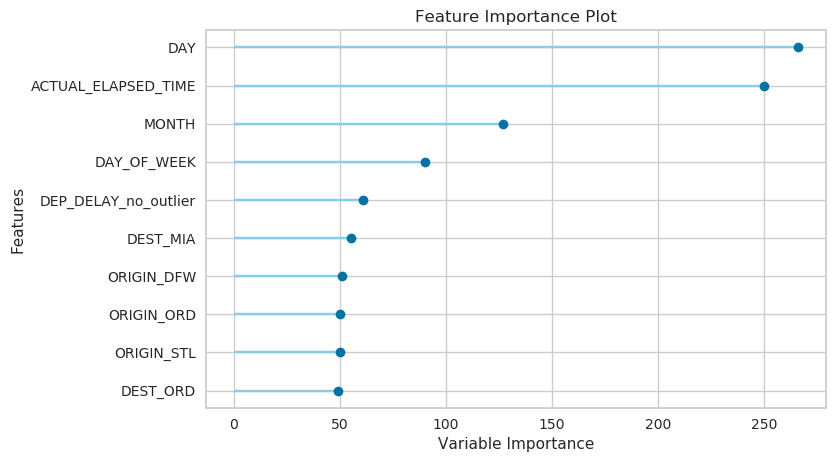

In [41]:
plot_model(tuned_lightgbm, plot='feature')

### ii. Confusion Matrix

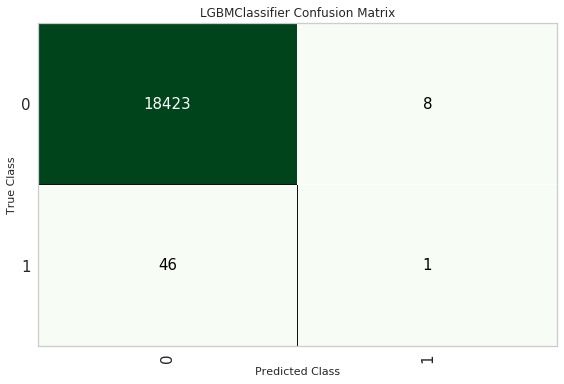

In [42]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')